In [ ]:
# Install TensorFlow 2.15 (closest stable version)
!pip install tensorflow==2.15.1

# Verify installation
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

TensorFlow version: 2.17.1


In [ ]:
# Install and set up Kaggle
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/Training/glioma/Tr-gl_0712.jpg  
  inflating: data/Training/glioma/Tr-gl_0713.jpg  
  inflating: data/Training/glioma/Tr-gl_0714.jpg  
  inflating: data/Training/glioma/Tr-gl_0715.jpg  
  inflating: data/Training/glioma/Tr-gl_0716.jpg  
  inflating: data/Training/glioma/Tr-gl_0717.jpg  
  inflating: data/Training/glioma/Tr-gl_0718.jpg  
  inflating: data/Training/glioma/Tr-gl_0719.jpg  
  inflating: data/Training/glioma/Tr-gl_0720.jpg  
  inflating: data/Training/glioma/Tr-gl_0721.jpg  
  inflating: data/Training/glioma/Tr-gl_0722.jpg  
  inflating: data/Training/glioma/Tr-gl_0723.jpg  
  inflating: data/Training/glioma/Tr-gl_0724.jpg  
  inflating: data/Training/glioma/Tr-gl_0725.jpg  
  inflating: data/Training/glioma/Tr-gl_0726.jpg  
  inflating: data/Training/glioma/Tr-gl_0727.jpg  
  inflating: data/Training/glioma/Tr-gl_0728.jpg  
  inflating: data/Training/glioma/Tr-gl_0729.jpg  
  inflating: data/Training/glio

In [ ]:

# Import necessary libraries
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image

print('Modules loaded')

# Generate data paths with labels
def generate_dataframe(data_dir):
    filepaths, labels = [], []
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

train_data_dir = '/content/data/Training'
test_data_dir = '/content/data/Testing'

train_df = generate_dataframe(train_data_dir)
test_df = generate_dataframe(test_data_dir)

valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)

# Image preprocessing
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', batch_size=batch_size, shuffle=True)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                      class_mode='categorical', batch_size=batch_size, shuffle=False)

# Model structure
img_shape = (img_size[0], img_size[1], 3)
class_count = len(train_gen.class_indices)

model = Sequential([
    Conv2D(64, (3, 3), activation="relu", input_shape=img_shape, padding="same"),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation="relu", padding="same"),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation="relu", padding="same"),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dense(64, activation="relu"),
    Dense(class_count, activation="softmax")
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Modules loaded
Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_28 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_30 (Conv2D)          (None, 112, 112, 128)     147

In [ ]:
# Training
epochs = 15
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, shuffle=False)

# Evaluation
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

# Save the model
model.save('Brain_Tumors.h5')

In [ ]:
# Prediction for a single image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# Load the saved model
model = load_model('Brain_Tumors.h5')
image_path = '/content/Te-noTr_0006.jpg'
image = Image.open(image_path)
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
prediction = model.predict(np.expand_dims(img_array, axis=0))
predicted_class_index = np.argmax(prediction)
predicted_class = list(test_gen.class_indices.keys())[predicted_class_index]

print("Predicted class:", predicted_class)

OSError: No file or directory found at Brain_Tumors.h5

In [ ]:
# Download the dataset using Kaggle API
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# Unzip the downloaded file
!unzip lgg-mri-segmentation.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  lgg-mri-segmentation.zip
replace /content/kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
# Navigate to My Drive directory to store the dataset
%cd /content/kaggle_3m


/content/kaggle_3m


In [ ]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

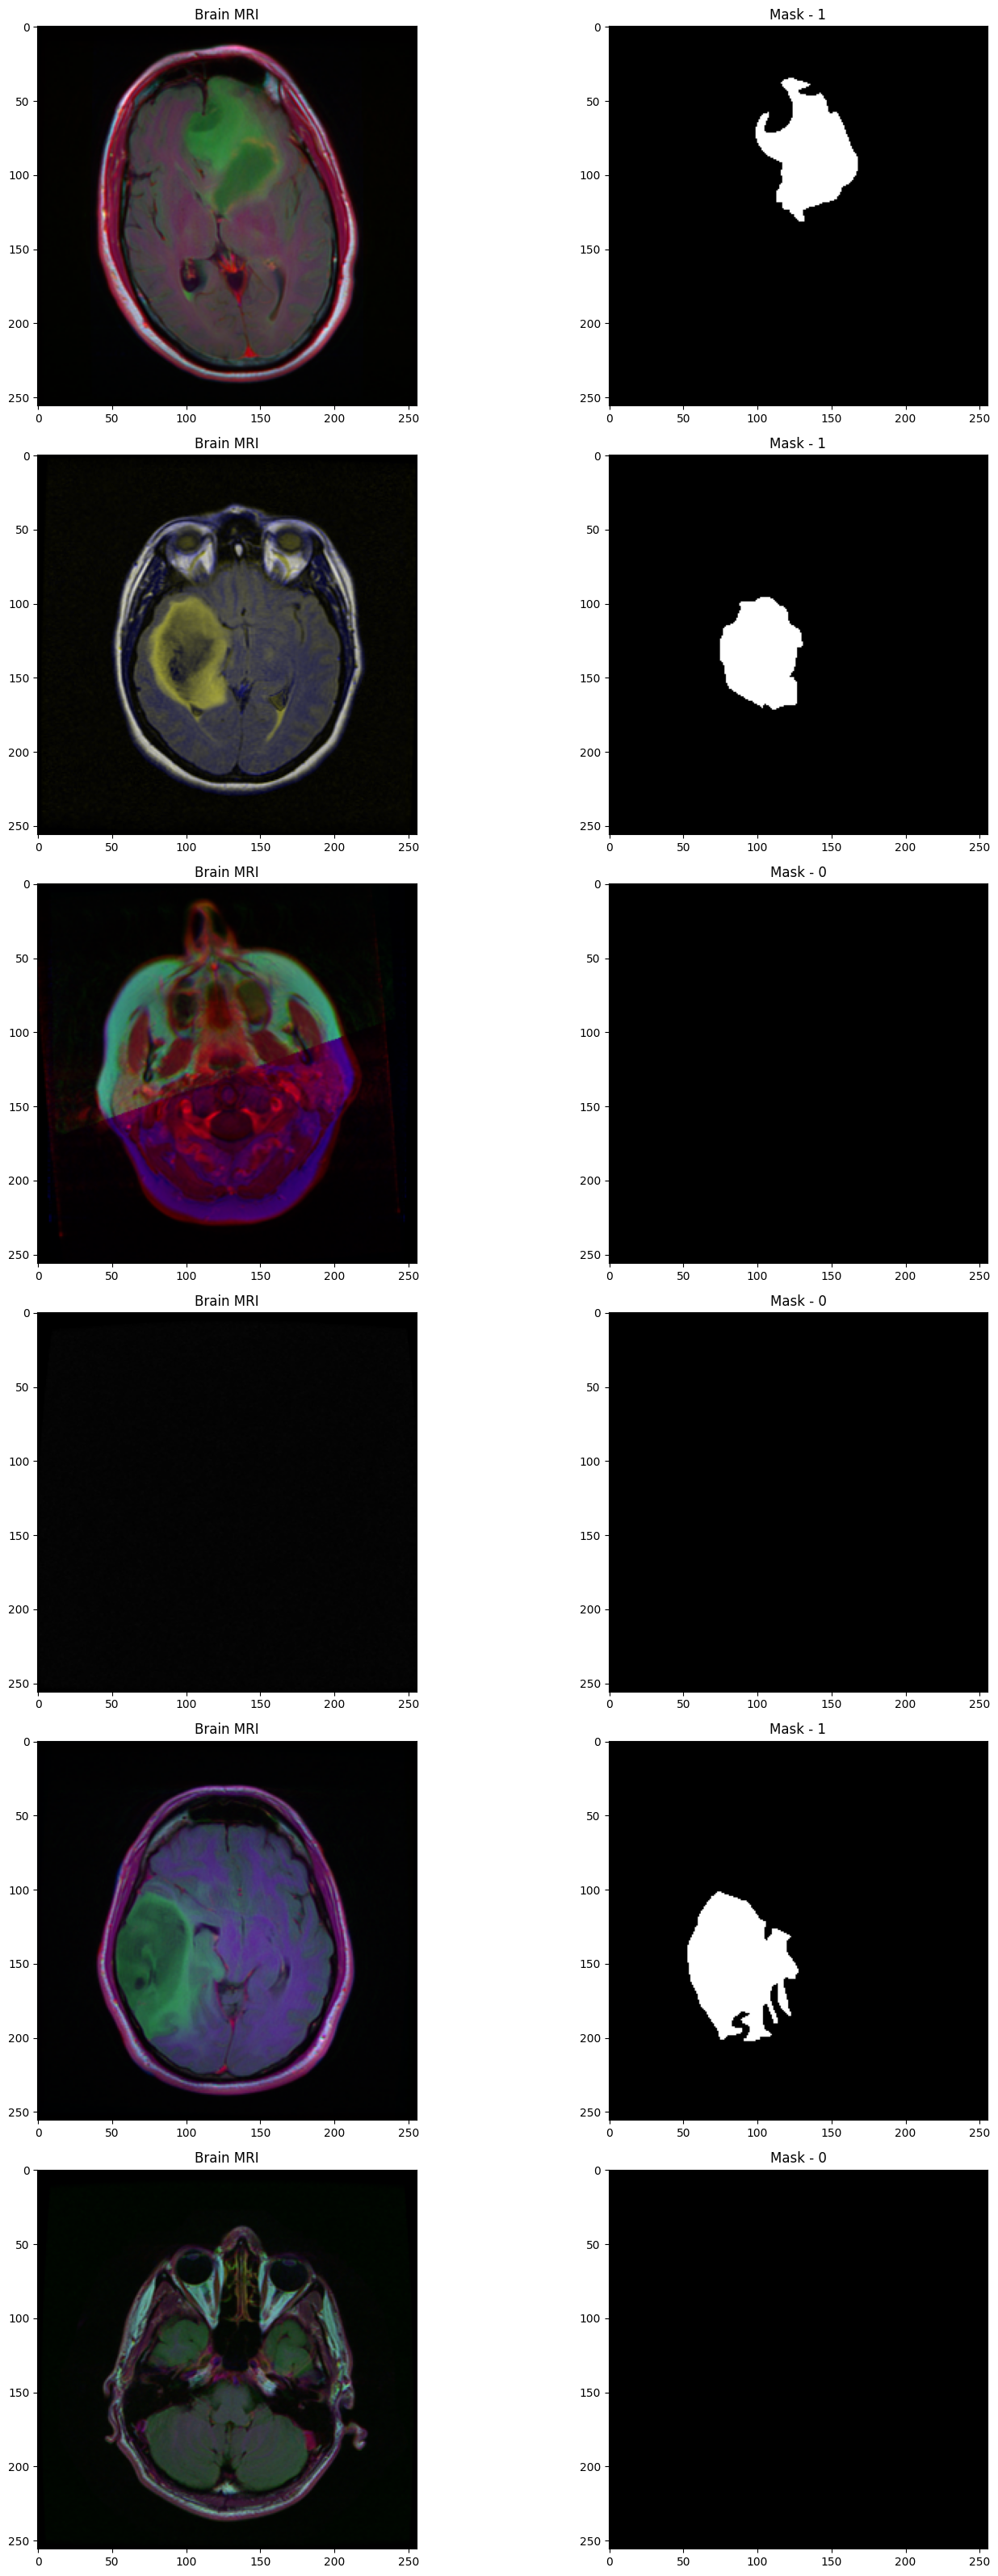

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

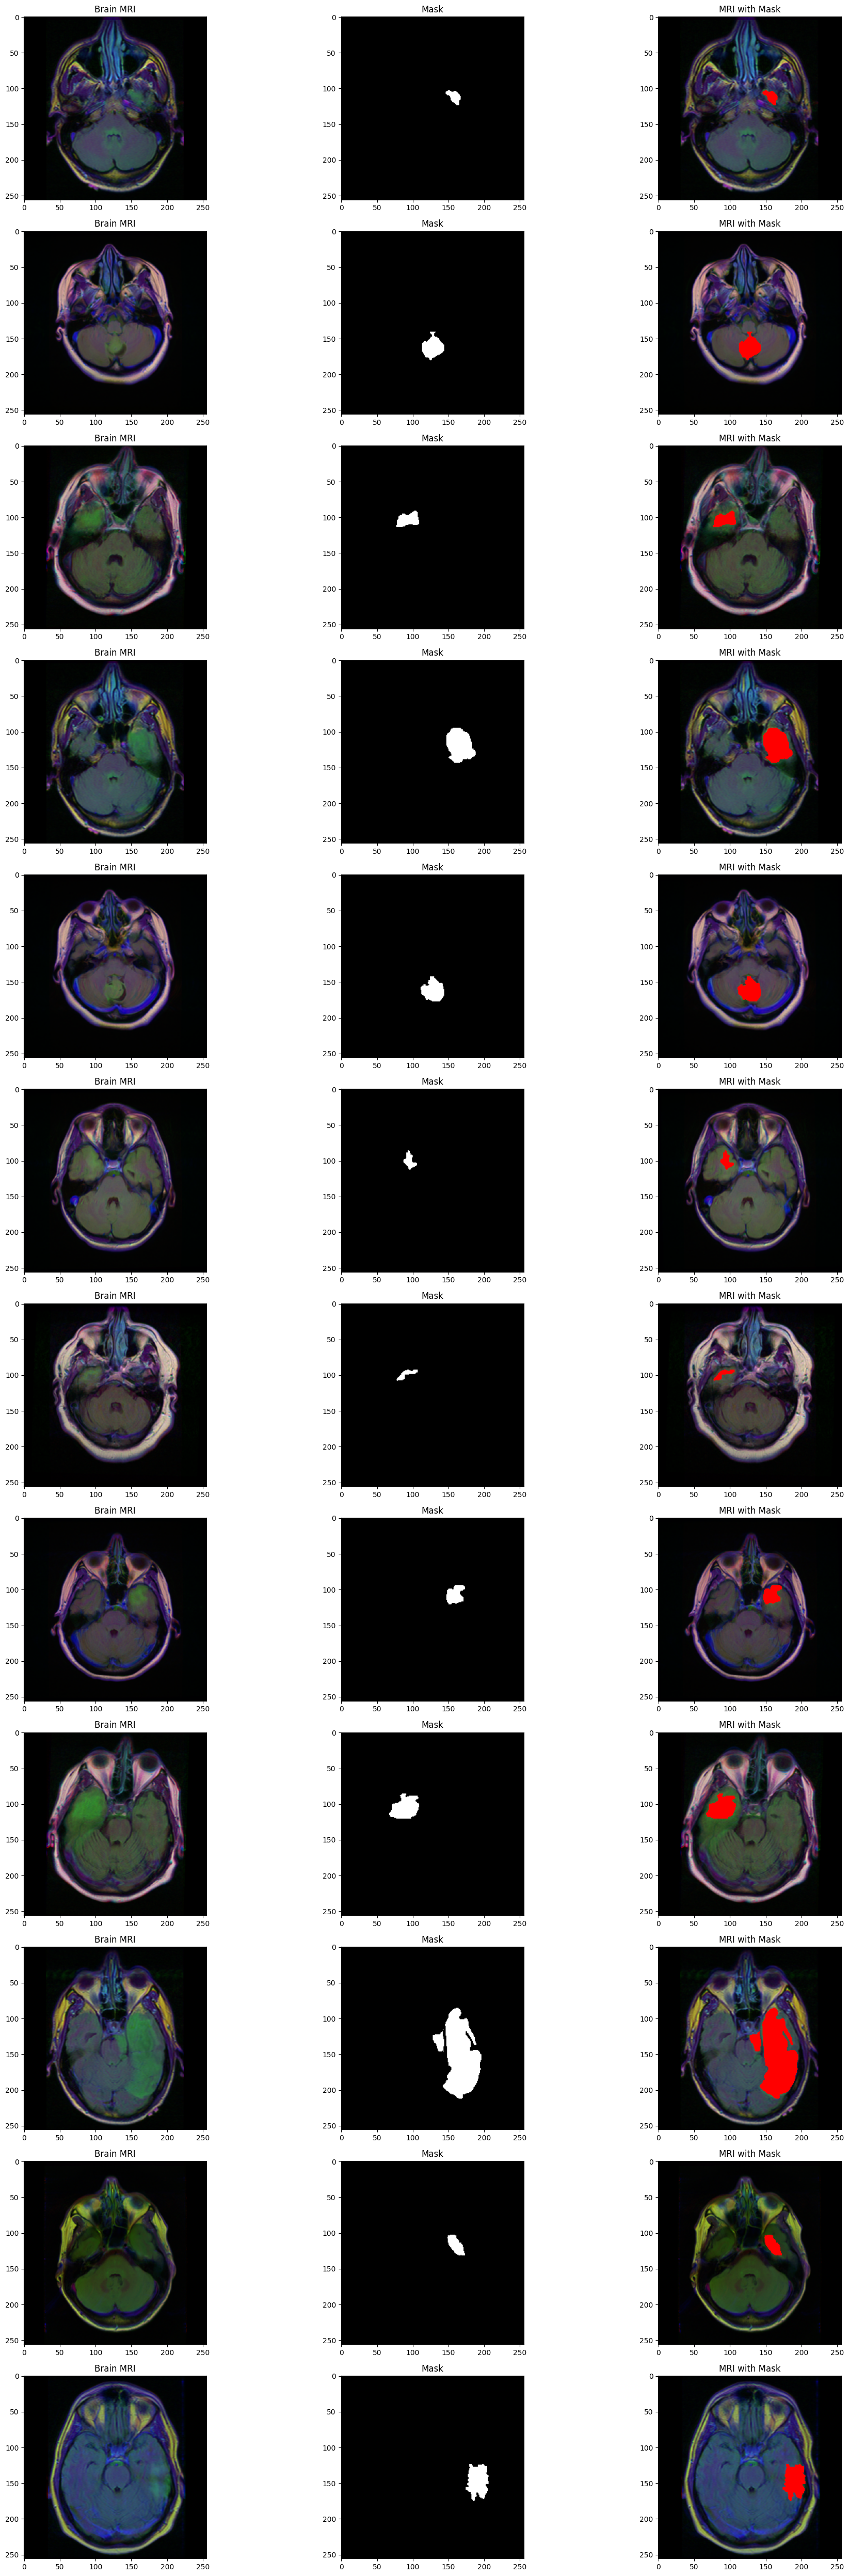

In [ ]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
!pip install keras_preprocessing

In [ ]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.keras", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.8480 - accuracy: 0.7340
Epoch 1: val_loss improved from inf to 4.98107, saving model to classifier-resnet-weights.keras
177/177 [==============================] - 106s 297ms/step - loss: 0.8480 - accuracy: 0.7340 - val_loss: 4.9811 - val_accuracy: 0.6633


In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
import tensorflow as tf

# Load the model architecture
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()

# Load the model architecture from JSON
try:
    model = tf.keras.models.model_from_json(json_savedModel)
except TypeError as e:
    print("Error loading model:", e)

# Load the weights
model.load_weights('weights.hdf5')

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary to verify
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 4s 72ms/step


In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9861111111111112

<Axes: >

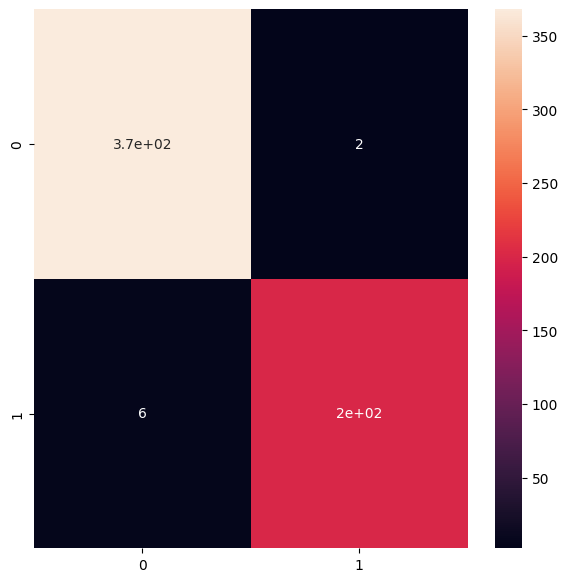

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       370
           1       0.99      0.97      0.98       206

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.98      0.98       576
weighted avg       0.99      0.99      0.99       576



In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.keras", verbose=1, save_best_only=True)

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

1/1 [==============================] - 1s 795ms/step
Tumor detected in /content/Te-gl_0027.jpg.


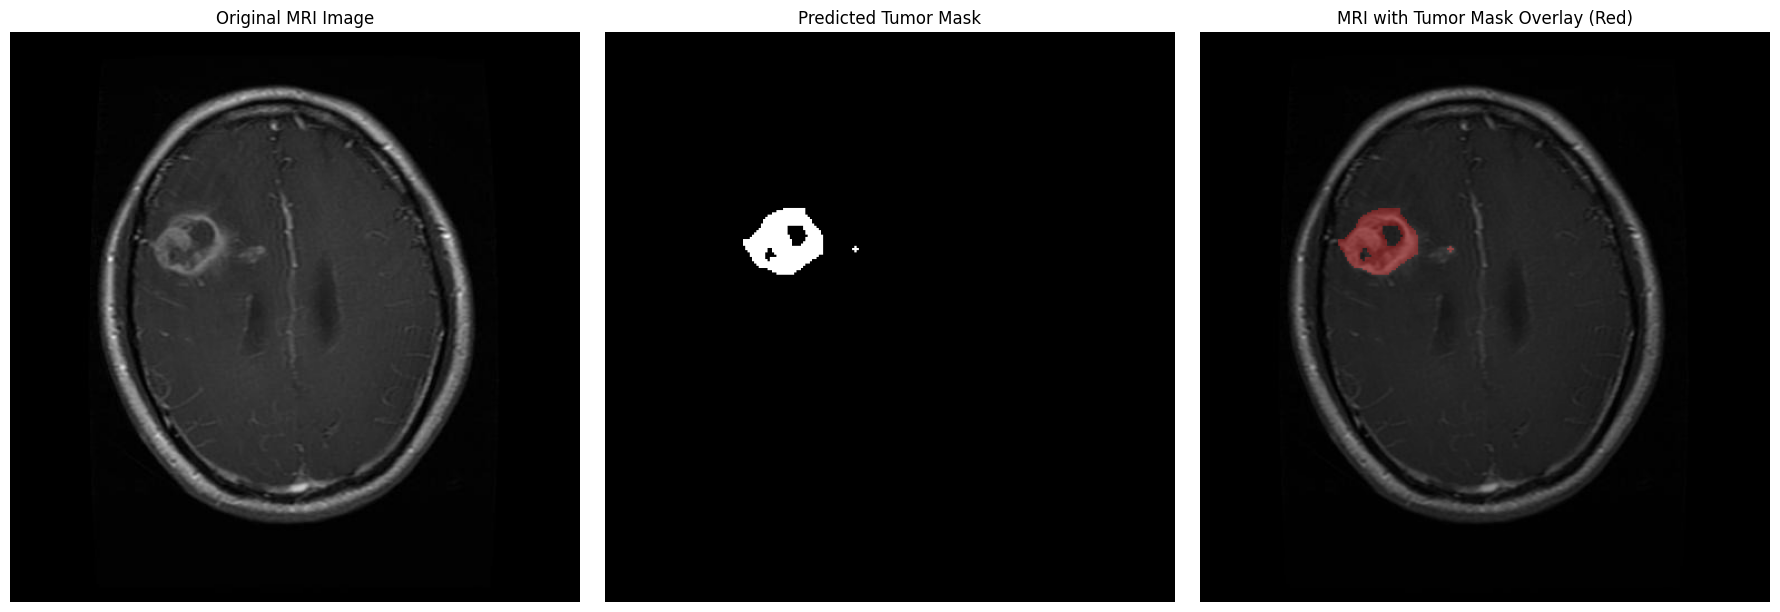

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from skimage import io
import matplotlib.pyplot as plt

# Load Classification Model
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load Segmentation Model
with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()

model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

def predict_tumor_single_image(image_path, model_classification, model_segmentation):
    """
    Predicts tumor presence and segmentation mask for a single MRI image.

    Parameters:
        image_path (str): Path to the MRI image.
        model_classification: Pre-trained classification model.
        model_segmentation: Pre-trained segmentation model.

    Returns:
        dict: Prediction results with tumor status and mask (if applicable).
    """
    # Read and preprocess the image
    img = io.imread(image_path)
    img = img * 1.0 / 255.0  # Normalize pixel values
    img_resized = cv2.resize(img, (256, 256))  # Resize image
    img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    # Classification Step
    is_defect = model_classification.predict(img_array)
    if np.argmax(is_defect) == 0:  # Tumor not detected
        return {
            "image_path": image_path,
            "has_tumor": False,
            "mask": None
        }

    # Segmentation Step
    img_standardized = img_resized - np.mean(img_resized)
    img_standardized /= np.std(img_standardized)
    img_standardized = np.expand_dims(img_standardized, axis=0)

    predicted_mask = model_segmentation.predict(img_standardized).squeeze()
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    return {
        "image_path": image_path,
        "has_tumor": True,
        "mask": binary_mask
    }

# Example Prediction for a Single Image
image_path = "/content/Te-gl_0027.jpg"  # Replace with the path to your MRI image
result = predict_tumor_single_image(image_path, model, model_seg)

# Display Result
if result["has_tumor"]:
    print(f"Tumor detected in {result['image_path']}.")

    # Load and preprocess the original MRI image
    img = io.imread(result["image_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Resize the predicted mask to match the original image dimensions
    resized_mask = cv2.resize(result["mask"], (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a red overlay where the mask is white
    mask_red = np.zeros_like(img_rgb)  # Blank image with the same dimensions as the MRI
    mask_red[resized_mask == 1] = [255, 0, 0]  # Fill white regions of the mask with red

    # Blend the original image with the red overlay
    blended_image = cv2.addWeighted(img_rgb, 0.7, mask_red, 0.3, 0)  # Blend with transparency (alpha)

    # Display the results
    plt.figure(figsize=(18, 6))

    # Original MRI Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original MRI Image")
    plt.axis("off")

    # Predicted Tumor Mask (binary)
    plt.subplot(1, 3, 2)
    plt.imshow(resized_mask, cmap='gray')
    plt.title("Predicted Tumor Mask")
    plt.axis("off")

    # MRI with Tumor Mask Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(blended_image)
    plt.title("MRI with Tumor Mask Overlay (Red)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print(f"No tumor detected in {result['image_path']}.")


In [ ]:
def get_tumor_location(mask, image_shape, anatomical_reference="head"):
    """
    Determines the approximate anatomical location of the tumor based on the predicted mask.

    Parameters:
        mask (numpy array): Binary mask where tumor pixels are 1, others are 0.
        image_shape (tuple): Shape of the MRI image (height, width, channels).
        anatomical_reference (str): The reference region of the body (default: "head").

    Returns:
        str: Scientific description of the tumor's location.
    """
    # Find the coordinates of the tumor (where the mask is non-zero)
    tumor_coords = np.argwhere(mask == 1)

    # Get the bounding box of the tumor
    y_min, x_min = tumor_coords.min(axis=0)
    y_max, x_max = tumor_coords.max(axis=0)

    # Determine the tumor's center coordinates
    tumor_center = ((y_min + y_max) // 2, (x_min + x_max) // 2)

    # Extract height and width from image shape
    height, width = image_shape[:2]  # Only take the first two dimensions (height, width)

    # Anatomical description based on the location of the tumor
    if anatomical_reference == "head":
        # Mapping the pixel coordinates to anatomical regions for head MRI scans
        if tumor_center[1] < width // 3:
            region = "left frontal lobe" if tumor_center[0] < height // 2 else "left temporal lobe"
        elif tumor_center[1] > 2 * width // 3:
            region = "right frontal lobe" if tumor_center[0] < height // 2 else "right temporal lobe"
        else:
            region = "parietal lobe" if tumor_center[0] < height // 2 else "occipital lobe"
    else:
        region = "Unknown anatomical region"  # Default if the body region is not specified

    return f"The tumor is located in the {region}, at approximately pixel coordinates (Y: {tumor_center[0]}, X: {tumor_center[1]}) in the MRI image."

# Example usage
if result["has_tumor"]:
    tumor_location = get_tumor_location(result["mask"], img_rgb.shape)
    print(f"Tumor Location: {tumor_location}")
else:
    print("No tumor detected.")


Tumor Location: The tumor is located in the left frontal lobe, at approximately pixel coordinates (Y: 93, X: 87) in the MRI image.


In [ ]:
import numpy as np

def calculate_tumor_stage(tumor_mask, pixel_spacing=(1.0, 1.0)):
    """
    Determines the tumor stage based on the predicted tumor mask.

    Parameters:
        tumor_mask (numpy array): Binary mask of the tumor (2D).
        pixel_spacing (tuple): Physical size of each pixel (e.g., in mm).

    Returns:
        dict: Tumor stage details (T stage, potential infiltration, etc.).
    """
    # Calculate tumor area
    tumor_area_pixels = np.sum(tumor_mask)  # Count white pixels (tumor)
    pixel_area_mm2 = pixel_spacing[0] * pixel_spacing[1]  # Area of a single pixel in mm²
    tumor_area_mm2 = tumor_area_pixels * pixel_area_mm2

    # Tumor size (T stage)
    max_tumor_diameter = np.sqrt(tumor_area_mm2 / np.pi) * 2  # Approximate diameter assuming a circular shape
    if max_tumor_diameter <= 20:  # ≤ 2 cm
        t_stage = "T1"
    elif 20 < max_tumor_diameter <= 50:  # 2–5 cm
        t_stage = "T2"
    elif max_tumor_diameter > 50:  # > 5 cm
        t_stage = "T3"
    else:
        t_stage = "T4 (infiltrating nearby structures)"

    # Check for irregular edges (indicative of infiltration)
    contours, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    irregularity = len(contours) > 1  # Multiple contours suggest irregularity

    # Return staging results
    return {
        "tumor_area_mm2": tumor_area_mm2,
        "max_diameter_mm": max_tumor_diameter,
        "t_stage": t_stage,
        "possible_infiltration": irregularity,
    }

# Example usage
# Assuming `result["mask"]` contains the binary tumor mask
pixel_spacing = (0.8, 0.8)  # Example: MRI pixel size is 0.8x0.8 mm
stage_info = calculate_tumor_stage(result["mask"], pixel_spacing)

print("Tumor Staging Results:")
print(f"Tumor Area: {stage_info['tumor_area_mm2']} mm²")
print(f"Max Diameter: {stage_info['max_diameter_mm']} mm")
print(f"T-Stage: {stage_info['t_stage']}")
print(f"Possible Infiltration: {'Yes' if stage_info['possible_infiltration'] else 'No'}")


Tumor Staging Results:
Tumor Area: 436.4800000000001 mm²
Max Diameter: 23.574214652581833 mm
T-Stage: T2
Possible Infiltration: Yes
